# Introduction

You probably want to do a similar coastal kelvin and Rossby wave propagation diagnostic for IOD and compare it to the SSH available.

What possible plots could you make?

Your coastal SLA diagrams could be useful.

Do a std of all data at a point versus seasonal plot and compare to SSH form real.

Does this need to be an SLA anomaly?

You should detrend 

regrid sla obs to model ssh since it's coarser

# Setup

In [1]:
# import your standard packages
%run ../../../global_tools/start.py

# import your local functions
sys.path.insert(1, '../')
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Fns

In [2]:
inpath = '/scratch/gpfs2/GEOCLIM/LRGROUP/Liao/MOM6-regional-0522-2021/ice_ocean_SIS2/regional_IndianOcean_control_config_025/'
outpath = '../../data/'

outfn = 'sla_regional_processed.nc'

# Get Regional Data

In [3]:
fns = sorted(glob.glob(inpath +'*dynamics2d_monthly*.nc')) # sorted() makes sure the files are sorted in time

# merge all ssh into one file
cnt = 0;
for ff, fn in enumerate(fns[:-1]):
    ds_in = xr.open_dataset(fn)
    
    print('processing: ', fn[-7:-3])
    
    if ff == 0:
        # intialize
        ssh = ds_in.SSH
        lat = ds_in.geolat
        lon = ds_in.geolon
    else:
        # add on current time step along time dimension
        ssh = xr.concat((ssh,ds_in.SSH),dim = 'time')
    
    cnt = cnt + ds_in.time.shape[0]

print('ssh final shape',ssh.shape)

processing:  2009
processing:  2010
processing:  2011
processing:  2012
processing:  2013
processing:  2014
processing:  2015
processing:  2016
processing:  2017
ssh final shape (108, 256, 428)


In [4]:
# convert to xarray dataset
ds_out = xr.Dataset(coords={'time': ssh.time})

# add variables to dataset
ds_out['mon_ssh']=xr.DataArray(ssh,dims = ['time','dimy', 'dimx'],
                     coords =[ssh.time,np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
ds_out['lat']=xr.DataArray(lat,dims = ['dimy', 'dimx'],
                     coords =[np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
ds_out['lon']=xr.DataArray(lon,dims = ['dimy', 'dimx'],
                     coords =[np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])
# convert to datetime format
datetimeindex = ds_out.indexes['time'].to_datetimeindex()
ds_out['time'] = datetimeindex
ds_out

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  if sys.path[0] == '':


<xarray.Dataset>
Dimensions:  (dimx: 428, dimy: 256, time: 108)
Coordinates:
  * time     (time) datetime64[ns] 2009-01-16T12:00:00 ... 2017-12-16T12:00:00
  * dimy     (dimy) int64 0 1 2 3 4 5 6 7 8 ... 248 249 250 251 252 253 254 255
  * dimx     (dimx) int64 0 1 2 3 4 5 6 7 8 ... 420 421 422 423 424 425 426 427
Data variables:
    mon_ssh  (time, dimy, dimx) float32 nan nan nan ... 0.7580824 0.75591826
    lat      (dimy, dimx) float32 -30.455408 -30.455408 ... 30.239664 30.239664
    lon      (dimy, dimx) float32 29.375 29.625 29.875 ... 135.875 136.125

In [24]:
ds_in.geolon[0:10,0]

<xarray.DataArray 'geolon' (yh: 10)>
array([29.375, 29.375, 29.375, 29.375, 29.375, 29.375, 29.375, 29.375, 29.375,
       29.375], dtype=float32)
Coordinates:
    xh       float64 29.38
  * yh       (yh) float64 -30.46 -30.24 -30.02 -29.81 ... -28.94 -28.72 -28.5
Attributes:
    long_name:     Longitude of tracer (T) points
    units:         degrees_east
    cell_methods:  time: point

# Regrid to even lat/lons

In [ ]:
lat = np.arange()
lon = 

xx,yy = np.meshgrid(ds_out.lon,ds_out.lat)
xx = xx.flatten()
yy = yy.flatten()

xx_SLA,yy_SLA = np.meshgrid(ds_SLA.lon,ds_SLA.lat)

mon_chl_mon_anom_SLA = np.zeros((len(ds_CHL.time),len(ds_SLA.lat),len(ds_SLA.lon)))*np.nan

for tt in tqdm(range(len(ds_CHL.time))):

    temp_chl = np.array(ds_CHL.mon_chl_mon_anom[tt,:,:])

    points = np.array( (xx,yy) ).T
    temp_values = temp_chl.flatten()

    mon_chl_mon_anom_SLA[tt,:,:] = griddata(points, temp_values, (xx_SLA,yy_SLA) ,method='linear')

ds_out = xr.Dataset(coords={'time': ds_CHL.time,
                        'lon': ds_SLA.lon,
                        'lat': ds_SLA.lat})
coords = [ds_CHL.time,ds_SLA.lat,ds_SLA.lon]
dims = ['time','lat','lon']

# add to dataset
ds_out['mon_chl_mon_anom'] = xr.DataArray(mon_chl_mon_anom_SLA,dims = dims,coords = coords)

# Find SLA anomaly relative to total mean

In [5]:

mean_ssh = ds_out.mon_ssh.mean()
mon_sla = ds_out.mon_ssh - mean_ssh

ds_out['mon_sla']=xr.DataArray(mon_sla,dims = ['time','dimy', 'dimx'],
                     coords =[ssh.time,np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])

# Detrend

In [6]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = mon_sla.stack(allpoints=['dimy','dimx'])

# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
mon_sla_slope, mon_sla_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
mon_sla_slope = np.reshape(mon_sla_slope, mon_sla.shape[1:3])
mon_sla_intercept = np.reshape(mon_sla_intercept, mon_sla.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
mon_sla_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
mon_sla_dtrnd = mon_sla_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
mon_sla_dtrnd = mon_sla_dtrnd.where(~np.isnan(mon_sla))

CPU times: user 2min 50s, sys: 3.38 s, total: 2min 54s
Wall time: 2min 39s


# Plot

/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Time')

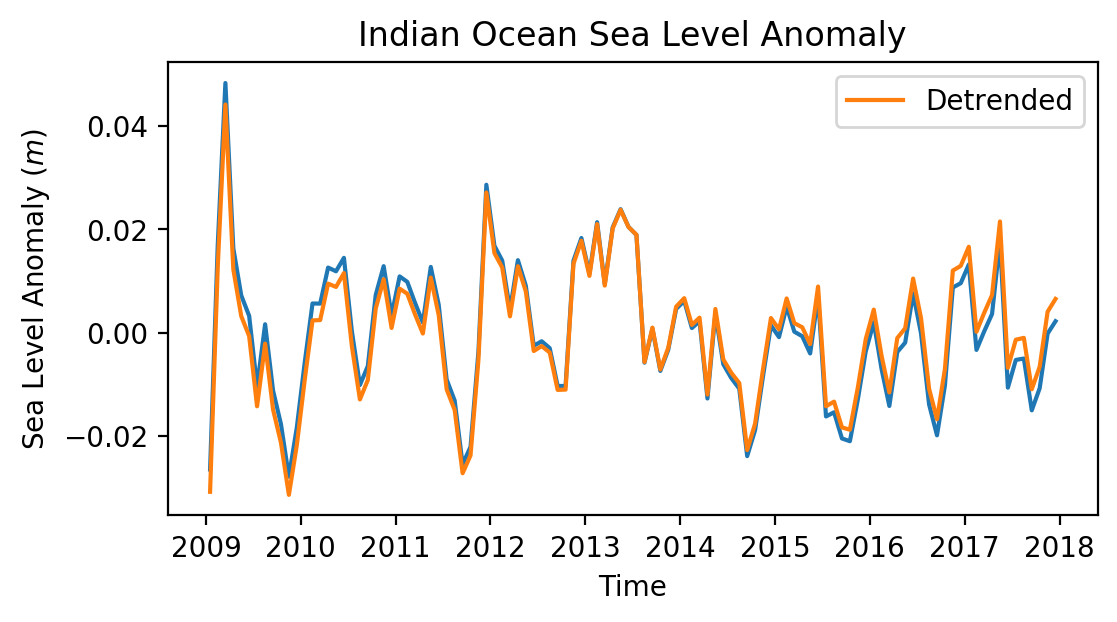

In [7]:
# find global means for comparison
stacked = mon_sla.stack(allpoints=['dimy','dimx'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
# global_mean.plot()

# find global means for comparison 
stacked = mon_sla_dtrnd.stack(allpoints=['dimy','dimx'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
# global_mean_dtrnd.plot()
# plt.legend


fig = plt.figure(figsize=(6,3),dpi=200)
plt.plot(global_mean.time,global_mean)
plt.plot(global_mean_dtrnd.time,global_mean_dtrnd, label = 'Detrended')
plt.legend()
plt.title('Indian Ocean Sea Level Anomaly')
plt.ylabel('Sea Level Anomaly ($m$)')
plt.xlabel('Time')

# Monthly Climatology

In [8]:
# monthly clim
mon_sla_mon_clim = monthly_clim(mon_sla_dtrnd)

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


# Find Coastlines

In [9]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = mon_sla_dtrnd[0,:,:]
xx=np.array(lon)
yy=np.array(lat)

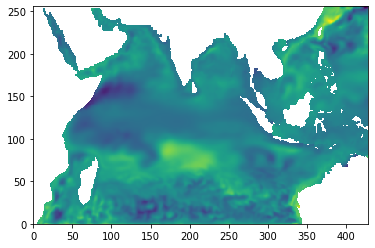

In [10]:
plt.pcolor(mask)

In [37]:
sta_loninds_unord[0],sta_latinds_unord[0]

(54, 128)

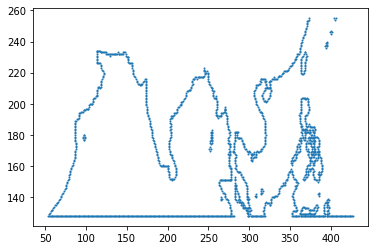

In [20]:
plt.scatter(sta_loninds_unord,sta_latinds_unord, s = 1)

IndexError: Unlabeled multi-dimensional array cannot be used for indexing: yh

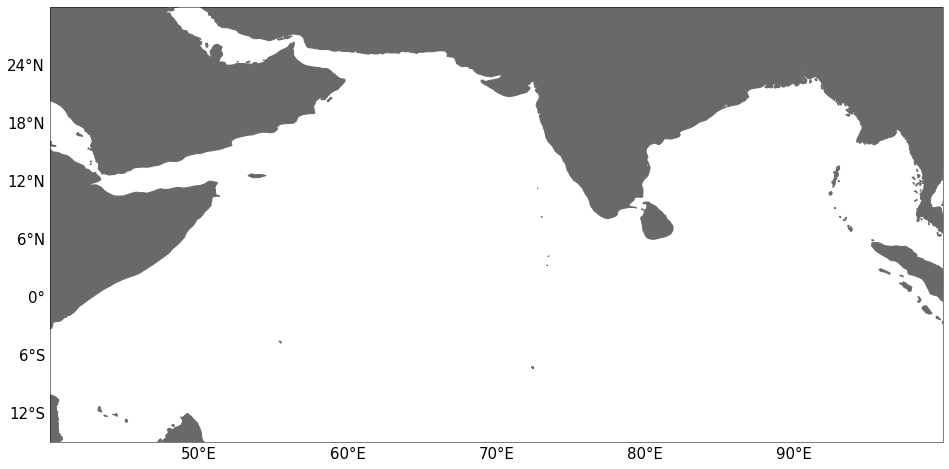

In [15]:
# set Gulfs to Nans
# mask = mask.where(~((yy>22) & (xx<57.5)))
# mask = mask.where(~((yy>10) & (xx<51)))

# # AS inlets
# mask = mask.where(~((yy>21.5) & (yy<23) & (xx>72) & (xx<73)))
# mask = mask.where(~((yy>22.25) & (yy<23) & (xx>69) & (xx<70.5)))
# mask = mask.where(~((yy>23.25) & (yy<24) & (xx>68.5) & (xx<70)))

# # sri lanka are
# mask = mask.where(~((yy>8) & (yy<10.5) & (xx>78) & (xx<80)))

# # Sumatra area
# mask = mask.where(~((yy>4.5) & (yy<5.5) & (xx>95.5) & (xx<100)))
# mask = mask.where(~((yy>3) & (yy<5.5) & (xx>97.5) & (xx<100)))
# mask = mask.where(~((yy>0) & (yy<10) & (xx>99) & (xx<100)))
# mask = mask.where(~((yy>0) & (yy<2.5) & (xx>97) & (xx<98)),1)

# # equator
# mask = mask.where(~(yy<0))
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])
    sta_mask = np.full(arr.shape,0)

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
#         cond = (~np.isnan(arr[row,col])) & (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),max(0,col-1):min(arr.shape[1],col+2)])))
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

#         if  (~np.isnan(arr[row,col])) & cond):
        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
            sta_mask[row,col] = 1
    
    return np.array(rowind), np.array(colind), sta_mask

sta_latinds_unord, sta_loninds_unord, sta_mask = find_coast(np.array(mask))
# # ------------------------------------------------------------#
# # Remove Manually some other points
# # ------------------------------------------------------------#

# sta_latinds_unord = sta_latinds_unord[46:]
# sta_loninds_unord = sta_loninds_unord[46:]

# sta_latinds_unord = sta_latinds_unord[125:]
# sta_loninds_unord = sta_loninds_unord[125:]

# # AS
# lons_from_sta = lon[sta_loninds_unord]
# lats_from_sta = lat[sta_latinds_unord]

# ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# #BoB
# lons_from_sta = lon[sta_loninds_unord]
# lats_from_sta = lat[sta_latinds_unord]

# ind = ~(lons_from_sta >99)
# sta_latinds_unord = sta_latinds_unord[ind]
# sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

bounds = [40,100,-15,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,bounds)
# cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# plt.scatter(lon[sta_loninds_unord],lat[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.scatter(lon[sta_mask],lat[sta_mask],
            s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
plt.colorbar(label = 'Station No.')
plt.title('Unordered Stations')

# Save

In [12]:
                    
ds_out['mon_sla']=mon_sla_dtrnd
ds_out['mon_sla_mon_clim']=xr.DataArray(mon_sla_mon_clim,dims = ['month','dimy', 'dimx'],
                     coords =[mon_sla_mon_clim.month,np.arange(ssh.shape[1]),np.arange(ssh.shape[2])])

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds_out.to_netcdf(outpath + outfn,mode='w',format = "NETCDF4")

ds_out

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/backends/file_manager.py", line 166, in acquire
    file = self._cache[self._key]
  File "/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/backends/lru_cache.py", line 43, in __getitem__
    value = self._cache[key]
KeyError: [<function _open_netcdf4_group at 0x7f22d7814bf8>, ('/projects/GEOCLIM/LRGROUP/jennap/enhui_reg_vs_glob/data/sla_regional_processed.nc', CombinedLock([<SerializableLock: a0aed97a-804f-432c-ac5f-b2acca49d137>, <SerializableLock: 42f9a6c4-4993-4f72-bba8-0aabbb22083a>, <unlocked _thread.lock object at 0x7f22d31703f0>])), 'a', (('clobber', True), ('diskless', False), ('format', 'NETCDF4'), ('group', None), ('persist', False))]

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/jennap/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3325, in run_code
    exec(code_o

TypeError: can only concatenate str (not "list") to str

In [ ]:
plt.pcolor(ds_out.mon_sla[0,:,:])